### Now we want to create new columsn that will assist in our analysis and visualizations on the datasight and improve ability to make insights

- Lets start by bringing in the most recent data subscriptions file within the db database

In [4]:
import sqlite3
import pandas as pd
from datetime import datetime
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your SQLite database
db_path = "Subscriptions.db"  # Adjust to your actual database path

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Find all subscription_data tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name LIKE 'subscription_data_%';")
tables = cursor.fetchall()

if not tables:
    print("No subscription_data tables found in the database.")
else:
    # Extract table names and sort them to find the most recent one
    subscription_tables = [table[0] for table in tables]
    latest_table = sorted(subscription_tables)[-1]
    
    print(f"Loading data from the most recent table: '{latest_table}'")
    
    # Query to get all data from the most recent table
    query = f"SELECT * FROM {latest_table}"
    
    # Load the data into a pandas DataFrame
    df = pd.read_sql_query(query, conn)
    
    # Display basic information about the DataFrame
    print(f"\nLoaded {len(df)} rows and {len(df.columns)} columns")
    print("\nDataFrame shape:", df.shape)
    print("\nColumn names:", list(df.columns))
    print("\nFirst 5 rows:")
    print(df.head())

# Close the connection
conn.close()

Loading data from the most recent table: 'subscription_data_20230116'

Loaded 134610 rows and 12 columns

DataFrame shape: (134610, 12)

Column names: ['oid', 'provider', 'total_charges', 'signup_date', 'is_canceled', 'is_active', 'is_delinquent', 'conversion_date', 'cancellation_date', 'current_mrr', 'personal_person_geo_country', 'converted']

First 5 rows:
               oid provider  total_charges          signup_date  is_canceled  \
0  273624174263463    apple          10.94  2021-04-20 00:00:00            1   
1  532534633483904    apple          10.92  2021-04-20 00:00:00            1   
2  623527156674739    apple           0.00  2021-04-20 00:00:00            0   
3  441616357320658    apple          90.30  2021-04-20 00:00:00            0   
4  189644194376891    apple          79.98  2021-04-20 00:00:00            0   

   is_active  is_delinquent      conversion_date    cancellation_date  \
0          0              0  2021-04-20 00:00:00  2021-05-20 00:00:00   
1          

### Now we want to think about columns that will assist us in generating useful insights about the data

### Before we start building seperate grouped views, lets add these columns to simplify the workstream 

- Lets start with adding in a payment periods column for customers who were or are active so we can divide total charges / payment periods and get an average MRR figure. 

In [5]:
def calculate_payment_periods(conversion_date, end_date, cancellation_date=None):
    """
    Calculate the number of monthly payment periods between conversion date and end date.
    If cancellation date falls exactly on a payment date, that payment is not counted.
    """
    # Use earlier of end_date or cancellation_date if customer cancelled
    effective_end_date = cancellation_date if cancellation_date and cancellation_date < end_date else end_date
    
    # If they converted on the same day as end date, count as 1 payment
    if conversion_date == effective_end_date:
        return 1
        
    # Start counting from 1 for the initial payment
    payment_count = 1
    
    # Add months until we exceed the end date
    current_date = conversion_date
    while True:
        # Move to next month while handling month length differences
        year = current_date.year + (current_date.month == 12)
        month = (current_date.month % 12) + 1
        
        # Get days in the target month
        if month == 2:
            days_in_month = 29 if (year % 4 == 0 and year % 100 != 0) or year % 400 == 0 else 28
        elif month in [4, 6, 9, 11]:
            days_in_month = 30
        else:
            days_in_month = 31
            
        # Use same day if possible, otherwise last day of month
        day = min(conversion_date.day, days_in_month)
        
        # Create next payment date
        next_date = datetime(year, month, day)
        
        # KEY CHANGE: If cancellation date is exactly on this payment date, 
        # don't count this payment - exit the loop before incrementing
        if cancellation_date and next_date.date() == cancellation_date.date():
            break
            
        # Stop if next payment would be after end date
        if next_date > effective_end_date:
            break
            
        # Count this payment and continue
        payment_count += 1
        current_date = next_date
    
    return payment_count

In [6]:

# Now apply this function to your dataframe to calculate payment periods and related metrics
def add_payment_metrics(df):
    # Parse dates correctly
    date_columns = ['signup_date', 'conversion_date', 'cancellation_date']
    for col in date_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col])
    
    # Define end date (Jan 16, 2023 based on your table name)
    end_date = datetime(2023, 1, 16)
    
    # Create payment periods column (only for converted customers)
    df['payment_periods'] = np.nan
    
    # Apply the function to rows where conversion_date is not null
    mask = df['conversion_date'].notna()
    
    # Use apply with axis=1 to process each row
    df.loc[mask, 'payment_periods'] = df.loc[mask].apply(
        lambda row: calculate_payment_periods(
            row['conversion_date'], 
            end_date, 
            row['cancellation_date'] if pd.notna(row['cancellation_date']) else None
        ), 
        axis=1
    )
    
    # Calculate average monthly payment
    df['avg_monthly_payment'] = df['total_charges'] / df['payment_periods']
    
    # Calculate expansion ratio (current MRR / average monthly payment)
    df['expansion_ratio'] = df['current_mrr'] / df['avg_monthly_payment']
    
    # Flag for expansion (current MRR > average)
    df['has_expanded'] = df['expansion_ratio'] > 1.00  # Using 5% threshold to account for minor fluctuations
    
    return df

In [7]:
# Apply the function to your dataframe
df = add_payment_metrics(df)

# Print summary of the new columns
print("\nNew metrics added:")
print(f"Payment periods: {df['payment_periods'].describe()}")
print(f"Average monthly payment: {df['avg_monthly_payment'].describe()}")
print(f"Expansion ratio: {df['expansion_ratio'].describe()}")
print(f"Customers with revenue expansion: {df['has_expanded'].sum()} ({df['has_expanded'].mean()*100:.2f}%)")

# Show a sample of the data with the new columns
print("\nSample data with new columns:")
relevant_columns = ['oid', 'conversion_date', 'cancellation_date', 'total_charges', 
                    'current_mrr', 'payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded']
print(df[relevant_columns].head(10))


New metrics added:
Payment periods: count    80759.000000
mean         5.554341
std          4.837442
min          1.000000
25%          2.000000
50%          4.000000
75%          9.000000
max         21.000000
Name: payment_periods, dtype: float64
Average monthly payment: count    80759.000000
mean        10.312292
std         10.594757
min       -119.980000
25%          6.030909
50%          7.990000
75%          9.016667
max        114.980000
Name: avg_monthly_payment, dtype: float64
Expansion ratio: count    8.040000e+04
mean              inf
std               NaN
min     -5.470000e+03
25%      0.000000e+00
50%      2.499563e-01
75%      9.520845e-01
max               inf
Name: expansion_ratio, dtype: float64
Customers with revenue expansion: 10695 (7.95%)

Sample data with new columns:
               oid conversion_date cancellation_date  total_charges  \
0  273624174263463      2021-04-20        2021-05-20          10.94   
1  532534633483904      2021-04-20        2021-06-20  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [8]:

# Validate with sample of customers
def create_sample_for_validation(df):
    """
    Create a sample of customers for validation, including:
    - 2 highest total charges
    - 2 lowest non-zero total charges
    - Mix of cancelled and active customers
    """
    # Ensure we only look at converted customers
    converted_df = df[df['converted'] == 1].copy()
    
    # Get high value customers
    high_value = converted_df.nlargest(2, 'total_charges')
    
    # Get low value customers (excluding zeros)
    low_value = converted_df[converted_df['total_charges'] > 0].nsmallest(2, 'total_charges')
    
    # Get some cancelled customers
    cancelled = converted_df[
        (converted_df['is_canceled'] == 1) & 
        (~converted_df.index.isin(high_value.index)) & 
        (~converted_df.index.isin(low_value.index))
    ].sample(min(5, len(converted_df[converted_df['is_canceled'] == 1])))
    
    # Get some active customers
    active = converted_df[
        (converted_df['is_active'] == 1) & 
        (~converted_df.index.isin(high_value.index)) & 
        (~converted_df.index.isin(low_value.index)) &
        (~converted_df.index.isin(cancelled.index))
    ].sample(min(5, len(converted_df[converted_df['is_active'] == 1])))
    
    # Combine samples
    sample_df = pd.concat([high_value, low_value, cancelled, active])
    
    # Select relevant columns
    cols = ['oid', 'conversion_date', 'cancellation_date', 'total_charges', 
            'current_mrr', 'payment_periods', 'avg_monthly_payment', 
            'expansion_ratio', 'has_expanded', 'is_canceled', 'is_active']
    
    return sample_df[cols].sort_values('total_charges', ascending=False)



In [9]:
# Create and display validation sample
validation_sample = create_sample_for_validation(df)
print("\nValidation Sample (including highest/lowest charges and mix of customers):")
pd.set_option('display.max_columns', None)
print(validation_sample)



Validation Sample (including highest/lowest charges and mix of customers):
                       oid conversion_date cancellation_date  total_charges  \
20317   cus_KhL3jKIuY9kNh9      2021-12-01               NaT         293.58   
16655   cus_Kdu6gDt3u6zF6i      2021-11-26               NaT         219.96   
23876      567592864021542      2021-12-11        2022-11-11          85.14   
92558      245557665570401      2022-10-02               NaT          59.99   
95034      637462239004810      2022-10-11               NaT          58.43   
113347  cus_MqJCxVXKwt8Ak7      2022-12-05               NaT          54.99   
30303   cus_KuwojneWbh6j2E      2022-01-21               NaT          54.99   
21882      581553385027561      2021-12-07        2022-05-07          39.95   
95780      595583125676653      2022-10-06               NaT          38.57   
103838  cus_MhHyZLeoyGxSRO      2022-10-28        2022-12-28          20.97   
460        665520790000313      2021-04-25        2022-

In [10]:

# For a few specific customers, show detailed payment period calculation
def explain_payment_periods(row, end_date=datetime(2023, 1, 16)):
    """Display detailed explanation of payment period calculation for a customer"""
    conversion_date = row['conversion_date']
    cancellation_date = row['cancellation_date'] if pd.notna(row['cancellation_date']) else None
    
    print(f"\nCustomer {row['oid']} Payment Details:")
    print(f"- Conversion date: {conversion_date.strftime('%Y-%m-%d')}")
    print(f"- End date: {end_date.strftime('%Y-%m-%d')}")
    
    if cancellation_date:
        print(f"- Cancellation date: {cancellation_date.strftime('%Y-%m-%d')}")
    
    # Effective end date
    effective_end_date = cancellation_date if cancellation_date and cancellation_date < end_date else end_date
    print(f"- Effective end date: {effective_end_date.strftime('%Y-%m-%d')}")
    
    # First payment
    print(f"- First payment: {conversion_date.strftime('%Y-%m-%d')} (initial)")
    
    # Calculate subsequent payments
    payment_count = 1
    current_date = conversion_date
    payment_dates = [current_date]
    
    while True:
        # Move to next month
        year = current_date.year + (current_date.month == 12)
        month = (current_date.month % 12) + 1
        
        # Get days in the target month
        if month == 2:
            days_in_month = 29 if (year % 4 == 0 and year % 100 != 0) or year % 400 == 0 else 28
        elif month in [4, 6, 9, 11]:
            days_in_month = 30
        else:
            days_in_month = 31
        
        # Use same day if possible, otherwise last day of month
        day = min(conversion_date.day, days_in_month)
        
        # Create next payment date
        next_date = datetime(year, month, day)
        
        # Stop if next payment would be after end date
        if next_date > effective_end_date:
            break
        
        # Count this payment and continue
        payment_count += 1
        current_date = next_date
        payment_dates.append(current_date)
    
    # List payment dates
    if len(payment_dates) <= 12:  # Show all if 12 or fewer
        print("- All payment dates:")
        for i, date in enumerate(payment_dates):
            print(f"  {i+1}. {date.strftime('%Y-%m-%d')}")
    else:  # Show first 6 and last 6 if more than 12
        print("- Selected payment dates (first 6 and last 6):")
        for i, date in enumerate(payment_dates[:6]):
            print(f"  {i+1}. {date.strftime('%Y-%m-%d')}")
        print("  ...")
        for i, date in enumerate(payment_dates[-6:]):
            print(f"  {len(payment_dates)-5+i}. {date.strftime('%Y-%m-%d')}")
    
    print(f"- Total payment periods: {payment_count}")
    print(f"- Total charges: ${row['total_charges']:.2f}")
    print(f"- Avg monthly payment: ${row['avg_monthly_payment']:.2f}")
    print(f"- Current MRR: ${row['current_mrr']:.2f}")
    print(f"- Expansion ratio: {row['expansion_ratio']:.2f}")
    print(f"- Has expanded: {'Yes' if row['has_expanded'] else 'No'}")


In [11]:

# Explain for a few representative customers
print("\nDetailed Payment Period Calculations:")

# Show for highest and lowest customers plus a mix of cases
for i in [0, 1, -2, -1]:  # First two (highest) and last two (lowest) in our sample
    explain_payment_periods(validation_sample.iloc[i])


Detailed Payment Period Calculations:

Customer cus_KhL3jKIuY9kNh9 Payment Details:
- Conversion date: 2021-12-01
- End date: 2023-01-16
- Effective end date: 2023-01-16
- First payment: 2021-12-01 (initial)
- Selected payment dates (first 6 and last 6):
  1. 2021-12-01
  2. 2022-01-01
  3. 2022-02-01
  4. 2022-03-01
  5. 2022-04-01
  6. 2022-05-01
  ...
  9. 2022-08-01
  10. 2022-09-01
  11. 2022-10-01
  12. 2022-11-01
  13. 2022-12-01
  14. 2023-01-01
- Total payment periods: 14
- Total charges: $293.58
- Avg monthly payment: $20.97
- Current MRR: $20.97
- Expansion ratio: 1.00
- Has expanded: No

Customer cus_Kdu6gDt3u6zF6i Payment Details:
- Conversion date: 2021-11-26
- End date: 2023-01-16
- Effective end date: 2023-01-16
- First payment: 2021-11-26 (initial)
- Selected payment dates (first 6 and last 6):
  1. 2021-11-26
  2. 2021-12-26
  3. 2022-01-26
  4. 2022-02-26
  5. 2022-03-26
  6. 2022-04-26
  ...
  9. 2022-07-26
  10. 2022-08-26
  11. 2022-09-26
  12. 2022-10-26
  13. 2

### Lets add a payment tier columns based on ranges of prices that we can use to see if certain prices offered to customers perform better

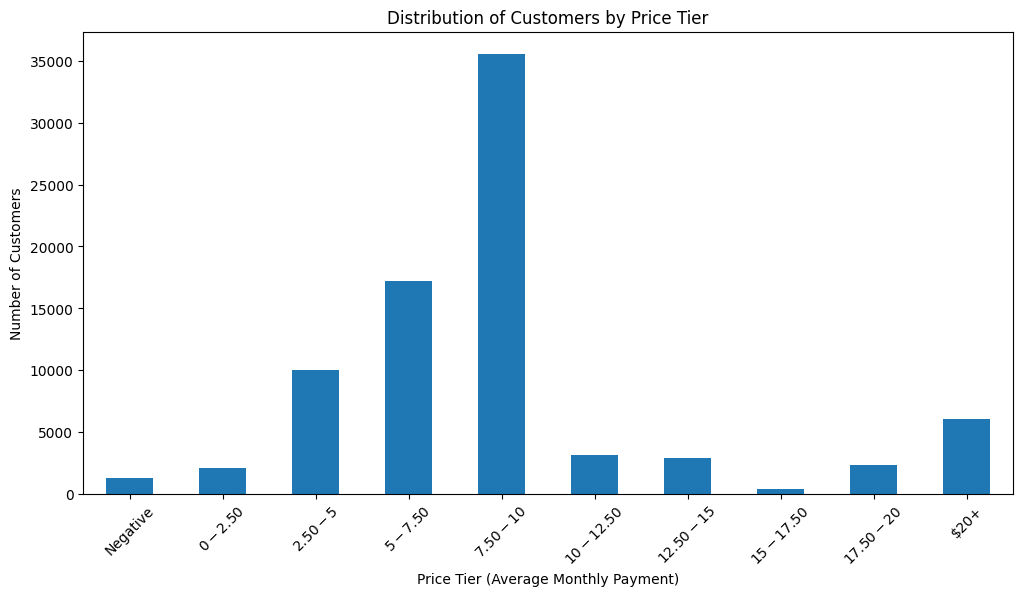

Customer count by price tier:
price_tier
Negative       1274
$0-$2.50       2037
$2.50-$5       9960
$5-$7.50      17192
$7.50-$10     35612
$10-$12.50     3113
$12.50-$15     2860
$15-$17.50      360
$17.50-$20     2311
$20+           6040
Name: count, dtype: int64

Rows without price tier assignment: 53851


In [12]:


# Create price tiers at $2.50 increments with special categories for negative and $20+
bins = [-float('inf'), 0, 2.50, 5.00, 7.50, 10.00, 12.50, 15.00, 17.50, 20.00, float('inf')]
labels = ['Negative', '$0-$2.50', '$2.50-$5', '$5-$7.50', '$7.50-$10', 
          '$10-$12.50', '$12.50-$15', '$15-$17.50', '$17.50-$20', '$20+']

# Add price_tier column to original dataframe (df)
# Rows without valid avg_monthly_payment will have NaN in the price_tier column
df['price_tier'] = pd.cut(df['avg_monthly_payment'], bins=bins, labels=labels)

# Plot histogram of price tiers (using only rows with valid price_tier)
plt.figure(figsize=(12, 6))
tier_counts = df['price_tier'].value_counts().sort_index()
tier_counts.plot(kind='bar')
plt.title('Distribution of Customers by Price Tier')
plt.xlabel('Price Tier (Average Monthly Payment)')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# Print the counts for each tier
print("Customer count by price tier:")
print(tier_counts)

# Print count of rows without price tier
print(f"\nRows without price tier assignment: {df['price_tier'].isna().sum()}")
# Reset any previous float formatting
pd.reset_option('display.float_format')

### Lets add a conversion speed metric to see if we are accelerating sign up to conversion to paid plan amongst cohorts

Conversion Speed Statistics (Days):
count    80759.000000
mean         5.059857
std         14.670057
min          0.000000
25%          0.000000
50%          0.000000
75%          7.000000
max        403.000000
Name: conversion_speed, dtype: float64


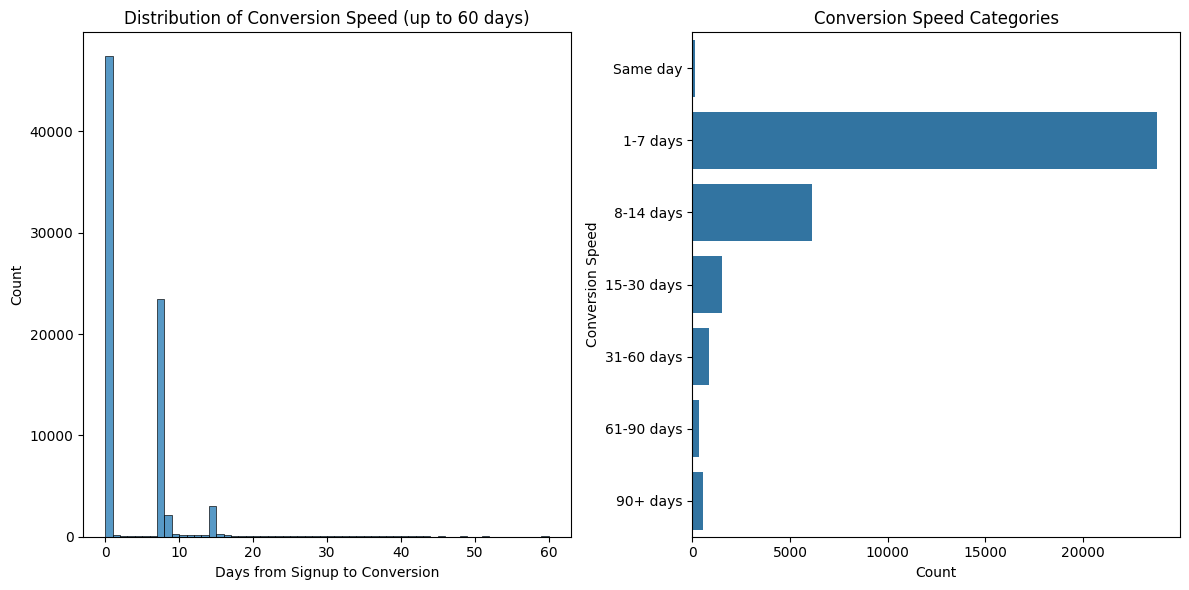


Customer count by conversion speed category:
conversion_speed_category
Same day        135
1-7 days      23806
8-14 days      6148
15-30 days     1507
31-60 days      851
61-90 days      337
90+ days        562
Name: count, dtype: int64

Rows with missing conversion speed: 53851


In [13]:

# Calculate conversion speed (days between signup and conversion)
df['conversion_speed'] = (df['conversion_date'] - df['signup_date']).dt.days

# Set negative values (conversion before signup) to 0
df.loc[df['conversion_speed'] < 0, 'conversion_speed'] = 0

# Print summary statistics
print("Conversion Speed Statistics (Days):")
print(df['conversion_speed'].describe())

# Create conversion speed category column
speed_bins = [0, 1, 7, 14, 30, 60, 90, float('inf')]
speed_labels = ['Same day', '1-7 days', '8-14 days', '15-30 days', 
                '31-60 days', '61-90 days', '90+ days']
df['conversion_speed_category'] = pd.cut(df['conversion_speed'], bins=speed_bins, labels=speed_labels)

# Plot the distribution of conversion speeds (capped at 60 days for better visualization)
plt.figure(figsize=(12, 6))

# Distribution histogram
plt.subplot(1, 2, 1)
sns.histplot(df[df['conversion_speed'] <= 60]['conversion_speed'], bins=60)
plt.title('Distribution of Conversion Speed (up to 60 days)')
plt.xlabel('Days from Signup to Conversion')
plt.ylabel('Count')

# Category bar chart
plt.subplot(1, 2, 2)
sns.countplot(y='conversion_speed_category', data=df, order=speed_labels)
plt.title('Conversion Speed Categories')
plt.xlabel('Count')
plt.ylabel('Conversion Speed')

plt.tight_layout()
plt.show()

# Print the counts for each category
print("\nCustomer count by conversion speed category:")
print(df['conversion_speed_category'].value_counts().sort_index())

# Check how many rows have missing conversion speed
print(f"\nRows with missing conversion speed: {df['conversion_speed'].isna().sum()}")

Signup Cohort distribution:
signup_cohort
2021-04     808
2021-05    1747
2021-06    1069
2021-07    1129
2021-08    1848
2021-09    2765
2021-10    3519
2021-11    7258
2021-12    8884
2022-01    7998
Name: count, dtype: int64

Conversion Cohort distribution:
conversion_cohort
2021-04     636
2021-05    1561
2021-06     967
2021-07     897
2021-08    1496
2021-09    2109
2021-10    2697
2021-11    3215
2021-12    4013
2022-01    3809
Name: count, dtype: int64


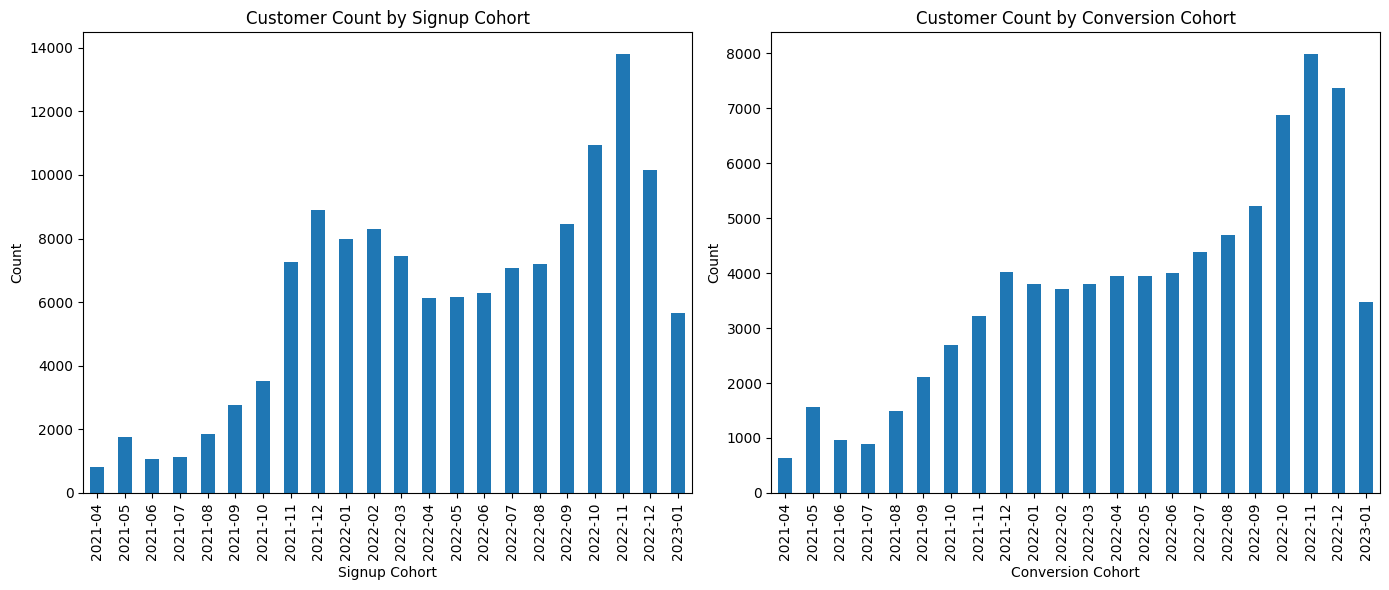


Rows missing signup cohort: 0
Rows missing conversion cohort: 53851


In [14]:

# Create Year-Month cohorts based on conversion and signup dates
df['conversion_cohort'] = df['conversion_date'].dt.strftime('%Y-%m')
df['signup_cohort'] = df['signup_date'].dt.strftime('%Y-%m')

# Print summary of cohorts
print("Signup Cohort distribution:")
print(df['signup_cohort'].value_counts().sort_index().head(10))  # Top 10 cohorts

print("\nConversion Cohort distribution:")
print(df['conversion_cohort'].value_counts().sort_index().head(10))  # Top 10 cohorts

# Plot cohort sizes
plt.figure(figsize=(14, 6))

# Signup cohorts
plt.subplot(1, 2, 1)
signup_counts = df['signup_cohort'].value_counts().sort_index()
signup_counts.plot(kind='bar')
plt.title('Customer Count by Signup Cohort')
plt.xlabel('Signup Cohort')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Conversion cohorts (excluding NaN for non-converted users)
plt.subplot(1, 2, 2)
conversion_counts = df['conversion_cohort'].value_counts().sort_index()
conversion_counts.plot(kind='bar')
plt.title('Customer Count by Conversion Cohort')
plt.xlabel('Conversion Cohort')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Also display the count of rows missing each cohort
print(f"\nRows missing signup cohort: {df['signup_cohort'].isna().sum()}")
print(f"Rows missing conversion cohort: {df['conversion_cohort'].isna().sum()}")

### Lets load up this table into our db for further use in other scripts

In [15]:


# Path to your SQLite database
db_path = "Subscriptions.db"  # Using the same path from your notebook

# Connect to the SQLite database (won't overwrite if it exists)
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Finding the latest signup date in the dataframe and formatting it for the table name
latest_signup_date = df['signup_date'].max()
formatted_date = latest_signup_date.strftime('%Y%m%d')

# Define the new table name with the metrics prefix
table_name = f"metrics_subscription_data_{formatted_date}"

# Check if this table already exists
cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}';")
table_exists = cursor.fetchone()

if table_exists:
    print(f"Table '{table_name}' already exists in the database. Overwriting")
    #print("If you want to replace it, you can use if_exists='replace' parameter.")
else:
    # Save the dataframe to the database
    df.to_sql(name=table_name, con=conn, if_exists='replace', index=False)
    print(f"Data successfully saved to table '{table_name}' in {db_path}")

# Get information about the saved table (number of rows)
cursor.execute(f"SELECT COUNT(*) FROM {table_name};")
row_count = cursor.fetchone()[0]
print(f"Total rows in '{table_name}': {row_count}")

# Get column information
cursor.execute(f"PRAGMA table_info({table_name});")
columns = cursor.fetchall()
print(f"\nTotal columns: {len(columns)}")
print("\nColumn information:")
for col in columns:
    print(f"  {col[1]} ({col[2]})")

# Close the connection
conn.close()

Data successfully saved to table 'metrics_subscription_data_20230116' in Subscriptions.db
Total rows in 'metrics_subscription_data_20230116': 134610

Total columns: 21

Column information:
  oid (TEXT)
  provider (TEXT)
  total_charges (REAL)
  signup_date (TIMESTAMP)
  is_canceled (INTEGER)
  is_active (INTEGER)
  is_delinquent (INTEGER)
  conversion_date (TIMESTAMP)
  cancellation_date (TIMESTAMP)
  current_mrr (REAL)
  personal_person_geo_country (TEXT)
  converted (INTEGER)
  payment_periods (REAL)
  avg_monthly_payment (REAL)
  expansion_ratio (REAL)
  has_expanded (INTEGER)
  price_tier (TEXT)
  conversion_speed (REAL)
  conversion_speed_category (TEXT)
  conversion_cohort (TEXT)
  signup_cohort (TEXT)


In [16]:


# Path to your SQLite database
db_path = "Subscriptions.db"  # Adjust to your actual database path

# Connect to the database
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# 1. List all tables in the database
print("All tables in the database:")
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table in tables:
    print(table[0])

# 2. Get the head of your newly created table
# (assuming the table name pattern is subscription_data_YYYYMMDD)
# Find the subscription_data table
subscription_tables = [table[0] for table in tables if table[0].startswith('metrics_subscription_data_')]

if subscription_tables:
    # Get the most recent table (should be the one you just created)
    latest_table = sorted(subscription_tables)[-1]
    
    print(f"\nFirst 5 rows from table '{latest_table}':")
    cursor.execute(f"SELECT * FROM {latest_table} LIMIT 5;")
    
    # Get column names
    column_names = [description[0] for description in cursor.description]
    print("Columns:", column_names)
    
    # Print rows
    rows = cursor.fetchall()
    for row in rows:
        print(row)
    
    # Also show a count of total rows
    cursor.execute(f"SELECT COUNT(*) FROM {latest_table};")
    row_count = cursor.fetchone()[0]
    print(f"\nTotal rows in '{latest_table}': {row_count}")
    
     # Add column count
    column_count = len(column_names)
    print(f"Total columns in '{latest_table}': {column_count}")
else:
    print("No subscription_data tables found.")

# Close the connection
conn.close()

All tables in the database:
subscription_data_20230116
metrics_subscription_data_20230116

First 5 rows from table 'metrics_subscription_data_20230116':
Columns: ['oid', 'provider', 'total_charges', 'signup_date', 'is_canceled', 'is_active', 'is_delinquent', 'conversion_date', 'cancellation_date', 'current_mrr', 'personal_person_geo_country', 'converted', 'payment_periods', 'avg_monthly_payment', 'expansion_ratio', 'has_expanded', 'price_tier', 'conversion_speed', 'conversion_speed_category', 'conversion_cohort', 'signup_cohort']
('273624174263463', 'apple', 10.94, '2021-04-20 00:00:00', 1, 0, 0, '2021-04-20 00:00:00', '2021-05-20 00:00:00', 0.0, 'France', 1, 1.0, 10.94, 0.0, 0, '$10-$12.50', 0.0, None, '2021-04', '2021-04')
('532534633483904', 'apple', 10.92, '2021-04-20 00:00:00', 1, 0, 0, '2021-04-20 00:00:00', '2021-06-20 00:00:00', 0.0, 'United Kingdom of Great Britain and Northern Ireland', 1, 2.0, 5.46, 0.0, 0, '$5-$7.50', 0.0, None, '2021-04', '2021-04')
('623527156674739', 'ap

In [17]:
df

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,personal_person_geo_country,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
0,273624174263463,apple,10.94,2021-04-20,1,0,0,2021-04-20,2021-05-20,0.00,France,1,1.0,10.940000,0.000000,False,$10-$12.50,0.0,NaN,2021-04,2021-04
1,532534633483904,apple,10.92,2021-04-20,1,0,0,2021-04-20,2021-06-20,0.00,United Kingdom of Great Britain and Northern I...,1,2.0,5.460000,0.000000,False,$5-$7.50,0.0,NaN,2021-04,2021-04
2,623527156674739,apple,0.00,2021-04-20,0,0,0,NaT,NaT,0.00,Germany,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2021-04
3,441616357320658,apple,90.30,2021-04-20,0,1,0,2021-04-27,NaT,3.47,Switzerland,1,21.0,4.300000,0.806977,False,$2.50-$5,7.0,1-7 days,2021-04,2021-04
4,189644194376891,apple,79.98,2021-04-20,0,1,0,2021-05-04,NaT,3.33,United States of America,1,21.0,3.808571,0.874344,False,$2.50-$5,14.0,8-14 days,2021-05,2021-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134605,cus_NB35AXFFLFDCQN,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01
134606,cus_NBFU1fiKQmfrD7,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01
134607,cus_NBJP0fuajs4kMo,stripe,7.99,2023-01-16,0,1,0,2023-01-16,NaT,7.99,None,1,1.0,7.990000,1.000000,False,$7.50-$10,0.0,NaN,2023-01,2023-01
134608,cus_NBH1IkjtW4wAYF,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01


In [ ]:


def calculate_revenue_retention(df):
    """
    Calculate revenue retention metrics
    
    Parameters:
    df (pandas.DataFrame): DataFrame with customer subscription data
    
    Returns:
    dict: Revenue retention metrics
    """
    # Gross Revenue Retention (GRR)
    # Considers only lost revenue from churned customers
    churned_mrr = df[df['is_canceled'] == 1]['current_mrr'].sum()
    total_initial_mrr = df['current_mrr'].sum()
    
    gross_revenue_retention = 1 - (churned_mrr / total_initial_mrr) if total_initial_mrr > 0 else 0
    
    # Net Revenue Retention (NRR)
    # Accounts for expansions and contractions in addition to churn
    # This requires tracking changes in MRR over time, which might need additional data
    
    # Basic metrics
    total_customers = len(df)
    converted_customers = df[df['converted'] == 1].shape[0]
    conversion_rate = converted_customers / total_customers if total_customers > 0 else 0
    
    # Churn analysis
    churned_customers = df[df['is_canceled'] == 1].shape[0]
    churn_rate = churned_customers / total_customers if total_customers > 0 else 0
    
    # Delinquency analysis
    delinquent_customers = df[df['is_delinquent'] == 1].shape[0]
    delinquency_rate = delinquent_customers / total_customers if total_customers > 0 else 0
    
    # Country-wise breakdown
    country_mrr = df.groupby('personal_person_geo_country')['current_mrr'].agg(['sum', 'count'])
    
    return {
        'total_customers': total_customers,
        'converted_customers': converted_customers,
        'conversion_rate': conversion_rate,
        'churned_customers': churned_customers,
        'churn_rate': churn_rate,
        'delinquent_customers': delinquent_customers,
        'delinquency_rate': delinquency_rate,
        'gross_revenue_retention': gross_revenue_retention,
        'total_mrr': total_initial_mrr,
        'country_mrr_breakdown': country_mrr
    }


In [19]:
retention_metrics = calculate_revenue_retention(df)

In [20]:
retention_metrics

{'total_customers': 134610,
 'converted_customers': 80759,
 'conversion_rate': 0.5999479979199168,
 'churned_customers': 33431,
 'churn_rate': 0.24835450560879577,
 'delinquent_customers': 90,
 'delinquency_rate': 0.0006685981724983285,
 'gross_revenue_retention': np.float64(1.0),
 'total_mrr': np.float64(280205.22),
 'country_mrr_breakdown':                                        sum  count
 personal_person_geo_country                      
 Albania                              71.04     34
 Algeria                              13.20      6
 Anguilla                              0.00      1
 Antarctica                            0.00      1
 Argentina                           404.07    227
 ...                                    ...    ...
 Venezuela (Bolivarian Republic of)   37.71     18
 Viet Nam                            473.05    524
 Virgin Islands (U.S.)                 0.00      1
 Zambia                                0.00      3
 Zimbabwe                             20.98 

In [21]:
df

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,personal_person_geo_country,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
0,273624174263463,apple,10.94,2021-04-20,1,0,0,2021-04-20,2021-05-20,0.00,France,1,1.0,10.940000,0.000000,False,$10-$12.50,0.0,NaN,2021-04,2021-04
1,532534633483904,apple,10.92,2021-04-20,1,0,0,2021-04-20,2021-06-20,0.00,United Kingdom of Great Britain and Northern I...,1,2.0,5.460000,0.000000,False,$5-$7.50,0.0,NaN,2021-04,2021-04
2,623527156674739,apple,0.00,2021-04-20,0,0,0,NaT,NaT,0.00,Germany,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2021-04
3,441616357320658,apple,90.30,2021-04-20,0,1,0,2021-04-27,NaT,3.47,Switzerland,1,21.0,4.300000,0.806977,False,$2.50-$5,7.0,1-7 days,2021-04,2021-04
4,189644194376891,apple,79.98,2021-04-20,0,1,0,2021-05-04,NaT,3.33,United States of America,1,21.0,3.808571,0.874344,False,$2.50-$5,14.0,8-14 days,2021-05,2021-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134605,cus_NB35AXFFLFDCQN,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01
134606,cus_NBFU1fiKQmfrD7,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01
134607,cus_NBJP0fuajs4kMo,stripe,7.99,2023-01-16,0,1,0,2023-01-16,NaT,7.99,None,1,1.0,7.990000,1.000000,False,$7.50-$10,0.0,NaN,2023-01,2023-01
134608,cus_NBH1IkjtW4wAYF,stripe,0.00,2023-01-16,0,0,0,NaT,NaT,0.00,None,0,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,2023-01


In [22]:
df[df['current_mrr'] > 10]
# .value_counts().sort_index()

,oid,provider,total_charges,signup_date,is_canceled,is_active,is_delinquent,conversion_date,cancellation_date,current_mrr,personal_person_geo_country,converted,payment_periods,avg_monthly_payment,expansion_ratio,has_expanded,price_tier,conversion_speed,conversion_speed_category,conversion_cohort,signup_cohort
177,588561920821079,apple,126.49,2021-04-22,0,1,0,2021-04-22,NaT,10.19,Russian Federation,1,21.0,6.023333,1.691754,True,$5-$7.50,0.0,NaN,2021-04,2021-04
1326,651497549947918,apple,46.53,2021-05-09,0,1,0,2021-05-09,NaT,10.24,Russian Federation,1,21.0,2.215714,4.621534,True,$0-$2.50,0.0,NaN,2021-05,2021-05
10952,539469426542643,apple,149.98,2021-10-14,0,1,0,2021-10-14,NaT,10.02,Mexico,1,16.0,9.373750,1.068943,True,$7.50-$10,0.0,NaN,2021-10,2021-10
11405,651508223845418,apple,97.83,2021-10-18,0,1,0,2021-10-25,NaT,11.18,Russian Federation,1,15.0,6.522000,1.714198,True,$5-$7.50,7.0,1-7 days,2021-10,2021-10
16436,cus_KduRix1yzTDqqo,stripe,125.82,2021-11-22,0,1,0,2021-11-22,NaT,13.98,None,1,14.0,8.987143,1.555556,True,$7.50-$10,0.0,NaN,2021-11,2021-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134247,679462279049836,apple,10.13,2023-01-15,0,1,0,2023-01-15,NaT,10.13,Russian Federation,1,1.0,10.130000,1.000000,False,$10-$12.50,0.0,NaN,2023-01,2023-01
134308,560582621658558,apple,10.13,2023-01-15,0,1,0,2023-01-15,NaT,10.13,Russian Federation,1,1.0,10.130000,1.000000,False,$10-$12.50,0.0,NaN,2023-01,2023-01
134347,GPA.3350-7902-4147-21930,google,10.07,2023-01-15,0,1,0,2023-01-15,NaT,10.07,Mexico,1,1.0,10.070000,1.000000,False,$10-$12.50,0.0,NaN,2023-01,2023-01
134359,203653421843811,apple,10.13,2023-01-15,0,1,0,2023-01-15,NaT,10.13,Russian Federation,1,1.0,10.130000,1.000000,False,$10-$12.50,0.0,NaN,2023-01,2023-01


In [23]:
cohort_counts = df.groupby('signup_cohort')['oid'].count().reset_index()
cohort_counts.columns = ['Signup Cohort', 'Customer Count']

# Sort chronologically
cohort_counts = cohort_counts.sort_values('Signup Cohort')

# Display results
print("Customer Count by Signup Cohort:")
print(cohort_counts)

# Optional: Calculate percentage of total
total_customers = cohort_counts['Customer Count'].sum()
cohort_counts['Percentage'] = (cohort_counts['Customer Count'] / total_customers * 100).round(2)

Customer Count by Signup Cohort:
   Signup Cohort  Customer Count
0        2021-04             808
1        2021-05            1747
2        2021-06            1069
3        2021-07            1129
4        2021-08            1848
5        2021-09            2765
6        2021-10            3519
7        2021-11            7258
8        2021-12            8884
9        2022-01            7998
10       2022-02            8302
11       2022-03            7466
12       2022-04            6116
13       2022-05            6148
14       2022-06            6279
15       2022-07            7072
16       2022-08            7209
17       2022-09            8472
18       2022-10           10929
19       2022-11           13795
20       2022-12           10144
21       2023-01            5653
